In [1]:
import csv
import pandas as pd
import numpy as np

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

from urllib.request import HTTPError

from matplotlib import pyplot as plt
from matplotlib import rcParams

In [2]:
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif' 
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.grid']=True
rcParams['axes.titlesize']=24
rcParams['axes.labelsize']=20
rcParams['axes.titlepad']=15
rcParams['legend.frameon'] = True
rcParams['legend.facecolor']='white'
rcParams['legend.fontsize']=18

In [3]:
def sources_f():
    raw_sources = list(csv.reader(open('sources.csv', 'r')))
    sources={}
    for line in raw_sources:
        state=line[0]
        sources[state] = dict(zip(['url',
                                   'col_tgt',
                                   'col_dates',
                                   'col_county'], 
                                  line[1:]))
    return sources
sources=sources_f()

abbrs = dict(csv.reader(open('abbrs.csv', 'r')))

#Create a date stamp to use in the "as of" plot titles
asof=pd.Timestamp(0)
#Define the population factor by which we will divide
factor=1.e5

In [4]:
def get_nc_url():
    #North Carolina is a pain.
    def wait(selector):
        el=WebDriverWait(driver, 
                         10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 
                                                                   selector)))
        return el

    driver = webdriver.Chrome("./chromedriver.exe")
    url = 'https://public.tableau.com/views/NCDHHS_COVID-19_DataDownload/DailyMetrics?:embed=y&:showVizHome=no&:host_url=https%3A%2F%2Fpublic.tableau.com%2F&:embed_code_version=3&:tabs=yes&:toolbar=no&:animate_transition=yes&:display_static_image=no&:display_spinner=no&:display_overlay=yes&:display_count=no&publish=yes&:loadOrderID=0'
    driver.get(url)
    
    #select the header so we get all the data
    selector='.tab-tvXLabel>.tvimagesContainer'
    wait(selector).click()
    
    selector='#download-ToolbarButton > span.tabToolbarButtonImg.tab-icon-download'
    driver.find_element_by_css_selector(selector).click()
    selector='#DownloadDialog-Dialog-Body-Id > div > button:nth-child(3)'
    wait(selector).click()
    window_after = driver.window_handles[1]
    driver.switch_to.window(window_after)
    selector='#tab-view-table-data-0'
    driver.find_element_by_css_selector(selector).click()
    selector='#tabContent-panel-underlying > div.tab-top-info > div:nth-child(2) > a'
    url_dat=wait(selector)
    url_txt=url_dat.get_attribute('href')
    driver.quit()
    return url_txt

def update_nc():
    #North carolina is a pain.
    with open('sources.csv','r') as f:
        reader=list(csv.reader(f))
        nc_line=[row for idx, row in enumerate(reader) if idx==2][0]
    nc_line[1]=get_nc_url()

    with open('test.csv', 'w') as f:
        writer=csv.writer(f)
        writer.writerow(nc_line)

    with open('sources.csv', 'w', newline='') as f:
        writer = csv.writer(f)   

        for line in reader:
            if line[0] == 'nc':
                writer.writerow(nc_line)
            else:
                writer.writerow(line)
    global sources
    sources=sources_f()
    return None

def get_pop(state, county):
    url='https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres.xlsx' 
    df=pd.read_excel(url, header=3)
    df.rename(columns={'Unnamed: 0':'county'}, errors='raise', inplace=True)
    i_note = np.where(df['county'].str.startswith('Note'))[0].min()
    df=df[:i_note]
    df['county'] = df.apply(lambda row: row['county'].replace('.','').lower(), axis=1)
    df.set_index('county', inplace=True)
    
    state=abbrs[state] #Get full state name
        
    def get_state(row):
        full = row.name #get the full `county, state` string
        if ',' in full:
            i = row.name.find(',')+2
            return full[i:] #return just the state
        else:
            return full
    df['state'] = df.apply(get_state, axis=1)
    
    if county=='all':
        return df.pivot_table(index='state', values=2019, aggfunc='sum').loc[state].values[0]
    else:
        irow = county.lower() + ' county, ' + state.lower()   
        return df.loc[irow,2019]

def newcases_f(state):
    d=sources[state]
    url=d['url']
    col_tgt=d['col_tgt']
    col_dates=d['col_dates']
    col_county=d['col_county']
    pop=get_pop(state, 'all')
    
    try:
        df = pd.read_csv(url, parse_dates=[col_dates])
    except HTTPError:
        #North Carolina is a pain. The URL for its data changes about
        #every half hour, so if we get an HTTP error, we need to 
        #webscrape to find the URL and update sources.csv.
        update_nc()
        d=sources[state]
        url=d['url']
        df = pd.read_csv(url, parse_dates=[col_dates])
    if state=='fl':
        #Florida releases data on each individual case, which
        #I guess is more robust, but we need to handle it
        #differently than the other dataframes.
        df[col_dates]=df.apply(lambda row: row[col_dates].tz_localize(None), axis=1)
        iscase=df[col_tgt]=='Yes'
        df_state=df[iscase].pivot_table(index=col_dates, 
                                        values=col_tgt, 
                                        aggfunc='count')
    else:
        if col_county=='':
            drop_cols=[col_dates]
        else:
            drop_cols=[col_county, col_dates]
        columns = df.drop(columns=drop_cols).columns

        df_state = df.groupby(col_dates)[columns].sum()
        
    global asof
    if df[col_dates].max() > asof:
        asof = df[col_dates].max()
    
    dates = df_state.index
    cases = df_state[col_tgt]/pop*factor
    cases7 = df_state[col_tgt].rolling('7D').mean()/pop*factor
    
    #Make the avg line only start after there's 7 days of data
    isearly = df_state.index < df_state.index[0] + pd.DateOffset(6)
    cases7[isearly] = np.nan
    
    return dates, cases, cases7

def newcases_county_f(state, county):
    d=sources[state]
    url=d['url']
    col_tgt=d['col_tgt']
    col_dates=d['col_dates']
    col_county=d['col_county']
    pop=get_pop(state, county)
    
    df = pd.read_csv(url, parse_dates=[col_dates], index_col=col_dates)
    iscounty = df[col_county]==county
    df=df[iscounty]
    
    dates = df.index
    cases = df[col_tgt]/pop*1.e3
    cases7 = df[col_tgt].rolling('7D').mean()/pop*factor
    
    #Make the avg line only start after there's 7 days of data
    isearly = df.index < df.index[0] + pd.DateOffset(6)
    cases7[isearly] = np.nan
    
    return dates, cases, cases7
    
def plt_newcases(bars=True): 
    
    fig=plt.figure(figsize=(8,7))
    ax=fig.add_subplot(111)
    
    for state, alpha, col in zip(['ca', 'ny', 'nc', 'fl'],
                                 [1., 0.75, 0.5, 0.5],                                 
                                 ['#1f77b4','#ff7f0e','#00e357', '#d62728']):
        cases=newcases_f(state)
        if bars:
            ax.bar(cases[0], cases[1], width=1.,
                   edgecolor='w', alpha=alpha,
                   label=state.upper())
        ax.plot(cases[0], cases[2], label='{0} 7-day avg'.format(state.upper()),
                color=col)
    
    fig.autofmt_xdate()
    ax.set_ylabel('Daily new cases / $10^5$ residents')
    ax.legend(fontsize=16)
    if bars:
        ax.grid()
    global asof
    ax.set_title('As of {0}'.format(asof.date()), fontsize=13)
    plt.show()
                     
    return None

def plt_newcases_county():
    cases_oc = newcases_county_f('ca', 'Orange')
    cases_bk = newcases_county_f('ny', 'Kings')
    cases_man = newcases_county_f('ny', 'New York')
    cases_la = newcases_county_f('ca', 'Los Angeles')
    
    fig = plt.figure(figsize=(8,7))
    ax=fig.add_subplot(111)
    for cases, label, col, line in zip([cases_oc, cases_la, cases_bk, cases_man],
                                       ['Orange County', 'LA County', 'Kings County', 'NY County'],
                                       ['#1f77b4','#1f77b4','#ff7f0e','#ff7f0e'],
                                       ['-','--','-','--']):
        ax.plot(cases[0], cases[2], ls=line, c=col, label=label)
    ax.set_ylabel('7-day avg new cases / $10^5$ residents', fontsize=16)
    ax.legend()
    fig.autofmt_xdate()
    global asof
    ax.set_title('As of {0}'.format(asof.date()), fontsize=13)
    plt.show()
    return None

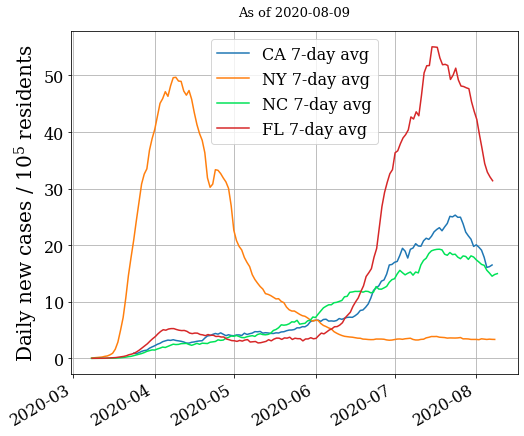

In [5]:
plt_newcases(bars=False)

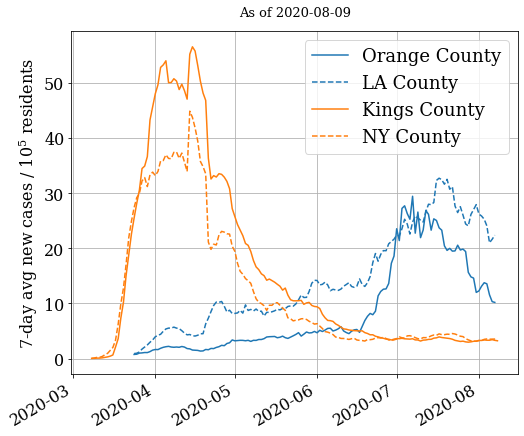

In [6]:
plt_newcases_county()